# PDF 보고서 인덱싱 및 테스트

> 목표: Knowledge Graph RAG 시스템 구축

## 환경 설정

In [1]:
from dotenv import load_dotenv

# 환경변수 로드
load_dotenv()

True

In [2]:
import os
from glob import glob

from pprint import pprint
import json

import re
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
from langfuse.langchain import CallbackHandler

# 콜백 핸들러 생성
langfuse_handler = CallbackHandler()

In [4]:
import nest_asyncio

# Jupyter 환경에서 비동기 이벤트 루프 중첩 허용
nest_asyncio.apply()

In [5]:
import pickle
import os

# 파싱된 문서 로드 (이전 작업 문서)
data_path = "data/population_reports/" 
with open(os.path.join(data_path, 'all_documents.pkl'), 'rb') as f:
    all_documents = pickle.load(f)

print(f"✅ all_documents 문서 로드 완료: {len(all_documents)}개 문서")


✅ all_documents 문서 로드 완료: 18개 문서


In [6]:
import os
from langchain_neo4j import Neo4jGraph

NEO4J_URI = "bolt://localhost:7687"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "11111111"
NEO4J_DATABASE = "reports"

# LangChain 도구 활용 - DB 연결 객체 초기화 
graph = Neo4jGraph( 
    url=NEO4J_URI, 
    username=NEO4J_USERNAME, 
    password=NEO4J_PASSWORD,
    database=NEO4J_DATABASE,
    )

graph.query("MATCH (n) RETURN n LIMIT 5;")

[{'n': {'id': 'parent_011',
   'source': '2025년_5월_경제활동인구조사_청년층_부가조사_결과_chunk_021-030.pdf'}},
 {'n': {'id': 'parent_004',
   'source': '2024년_인구주택총조사_결과(등록센서스_방식)_chunk_031-040.pdf'}},
 {'n': {'id': 'parent_006',
   'source': '2024년_인구주택총조사_결과(등록센서스_방식)_chunk_121-130.pdf'}},
 {'n': {'id': 'parent_003',
   'source': '2025년_5월_경제활동인구조사_청년층_부가조사_결과_chunk_011-020.pdf'}},
 {'n': {'id': 'parent_010',
   'source': '2024년_인구주택총조사_결과(등록센서스_방식)_chunk_051-060.pdf'}}]

In [ ]:
def reset_database(graph):
    """
    APOC 없이 데이터베이스 초기화하기
    """
    # 모든 노드와 관계 삭제
    graph.query("MATCH (n) DETACH DELETE n")
    
    # 모든 제약조건 삭제
    constraints = graph.query("SHOW CONSTRAINTS")
    for constraint in constraints:
        constraint_name = constraint.get("name")
        if constraint_name:
            graph.query(f"DROP CONSTRAINT {constraint_name}")
    
    # 모든 인덱스 삭제
    indexes = graph.query("SHOW INDEXES")
    for index in indexes:
        index_name = index.get("name")
        index_type = index.get("type")
        if index_name and index_type != "CONSTRAINT":
            graph.query(f"DROP INDEX {index_name}")
    
    print("데이터베이스가 초기화되었습니다.")

# 데이터베이스 초기화
# reset_database(graph)

데이터베이스가 초기화되었습니다.


---

## 1. 지식그래프 스키마 설계

In [9]:
# Document 노드 레이블 및 속성 정의 (제약조건 설정)
cypher_query = """
CREATE CONSTRAINT IF NOT EXISTS    // 제약조건 생성
FOR (d:Document)   // Document 레이블을 가진 노드에 대해
REQUIRE d.id IS UNIQUE;  // id 속성이 유일해야 함
"""

graph.query(cypher_query)

[]

In [10]:
# Chunk 노드 레이블 및 속성 정의 (제약조건 설정)
cypher_query = """
CREATE CONSTRAINT IF NOT EXISTS   // 제약조건 생성
FOR (c:Chunk)  // Chunk 레이블을 가진 노드에 대해
REQUIRE c.chunk_id IS UNIQUE;  // chunk_id 속성이 유일해야 함
"""

graph.query(cypher_query)

[]

In [11]:
# Table 노드 레이블 및 속성 정의 (제약조건 설정)
cypher_query = """
CREATE CONSTRAINT IF NOT EXISTS  // 제약조건 생성
FOR (t:Table)  // Table 레이블을 가진 노드에 대해
REQUIRE (t.name, t.document_id) IS NODE KEY; // name과 document_id 속성이 유일해야 함 (복합키)
"""

graph.query(cypher_query)

[]

In [12]:
# Image 노드 레이블 및 속성 정의 (제약조건 설정)
cypher_query = """
CREATE CONSTRAINT IF NOT EXISTS  // 제약조건 생성
FOR (i:Image)  // Image 레이블을 가진 노드에 대해
REQUIRE (i.name, i.document_id) IS NODE KEY; // name과 document_id 속성이 유일해야 함 (복합키)
"""

graph.query(cypher_query)

[]

In [13]:
# 벡터 인덱스 생성
cypher_query = """
CREATE VECTOR INDEX chunk_content_index IF NOT EXISTS
FOR (c:Chunk) 
ON (c.embedding)
OPTIONS {
  indexConfig: {
    `vector.dimensions`: 1536,
    `vector.similarity_function`: 'cosine'
  }
}
"""

graph.query(cypher_query)

cypher_query = """
CREATE VECTOR INDEX table_content_index IF NOT EXISTS
FOR (t:Table) 
ON (t.embedding)
OPTIONS {
  indexConfig: {
    `vector.dimensions`: 1536,
    `vector.similarity_function`: 'cosine'
  }
}
"""

graph.query(cypher_query)

cypher_query = """
CREATE VECTOR INDEX image_content_index IF NOT EXISTS
FOR (i:Image) 
ON (i.embedding)
OPTIONS {
  indexConfig: {
    `vector.dimensions`: 1536,
    `vector.similarity_function`: 'cosine'
  }
}
"""

graph.query(cypher_query)

[]

---

## 2. 인덱싱

### 1\) 원본 문서 노드 저장

In [14]:
import os, operator
from typing import Dict, Any, List, TypedDict
from typing_extensions import Annotated, Literal

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

# 상태 정의
class DocState(TypedDict):
    graph: Any                          # Neo4jGraph
    all_documents: Dict[str, Any]
    created: Annotated[List[str], operator.add]
    errors: Annotated[List[str], operator.add]

# 작업 코드 정의
def create_document_node(state: Dict[str, Any]):
    """
    문서 노드 생성 함수
    """
    graph = state["graph"]
    doc_id = state["doc_id"]
    source = state["source"]

    query = """
    MERGE (d:Document {id: $doc_id})
    SET d.source = $source
    RETURN d
    """

    try:
        graph.query(
            query,
            params={"doc_id": doc_id, "source": source}
        )
        return {"created": [doc_id]}
    except Exception as e:
        return {"errors": [f"{doc_id}: {e!r}"]}

def create_document_tasks(state: DocState) -> List[Send]:
    """
    모든 문서에 대한 노드 생성 작업을 Send 객체로 생성
    """
    tasks = []
    for key, doc in state['all_documents'].items():
        if not isinstance(doc, dict) or 'text_content' not in doc:
            continue

        params = {
            "graph": state['graph'],
            "doc_id": doc['parent_id'],
            "source": os.path.basename(key),
        }
        tasks.append(Send("create_document_node", params))
    
    return tasks


# 문서 노드 생성 작업 실행
builder = StateGraph(DocState)
builder.add_node("create_document_node", create_document_node)

builder.add_conditional_edges(START, create_document_tasks, ["create_document_node"])
builder.add_edge("create_document_node", END)

workflow = builder.compile()

# 실행 (병렬)
initial_state: DocState = {
    "graph": graph,                 # Neo4jGraph 인스턴스
    "all_documents": all_documents, # 문서 dict
    "created": [],
    "errors": [],
}

result = workflow.invoke(initial_state, config={"callbacks": [langfuse_handler]})

print("created:", len(result["created"]))
print("errors:", result["errors"])

created: 18
errors: []


Failed to send compressed multipart ingest: Connection error caused failure to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. The content length of 311183264 bytes exceeds the maximum size limit of 20971520 bytes. SSLError(MaxRetryError("HTTPSConnectionPool(host='api.smith.langchain.com', port=443): Max retries exceeded with url: /runs/multipart (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:2427)')))"))
Content-Length: 311183264
API Key: lsv2_********************************************b5trace=a079d0a7-b5de-4091-b71e-855ada3b976b,id=0346f5be-f4e7-40fb-97f5-487abe81a722; trace=a079d0a7-b5de-4091-b71e-855ada3b976b,id=9860d146-65a8-45d7-8272-aaeb54ff79d2; trace=a079d0a7-b5de-4091-b71e-855ada3b976b,id=a8ea670b-4645-4ad6-9afb-564ab7feb6f7; trace=a079d0a7-b5de-4091-b71e-855ada3b976b,id=989a0383-9f73-404c-af0e-65eb703fffba; trace=a079d0a7-b5de-4091-b71e-855ada3b976b,id=83a73e04-91cc-4e2a-8b0f-3b752fbc7687; trace=a079d0a7-b5de-4091-b71

### 2\) 페이지 이미지 내용 요약 및 저장

In [ ]:
import os, operator
from typing import Dict, Any, List, TypedDict
from typing_extensions import Annotated, Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

# 요약 체인 정의
system_message = """
당신은 한국의 인구 동향과 통계를 전문적으로 분석하는 인구학 전문가입니다.

다음 이미지 문서의 내용을 정확하고 체계적으로 요약해 주세요:

**분석 지침:**
1. **텍스트 내용**: 핵심 통계 수치, 증감률, 비율 등을 정확히 기록
2. **표(Table) 분석**: 
   - 표의 제목, 단위, 구성 요소를 명확히 파악
   - 행과 열의 데이터를 체계적으로 정리
   - 주요 수치와 변화 추이를 강조
3. **차트/그래프 분석**:
   - 차트 유형(막대, 선, 원형 등) 명시
   - X축, Y축의 의미와 범위 설명
   - 주요 데이터 포인트와 트렌드 파악
   - 비교 대상과 변화 패턴 분석
4. **이미지 내 텍스트**: 범례, 주석, 설명문 등 모든 텍스트 정보 포함

**요약 형식:**
- 문서 유형과 주제를 먼저 명시
- 핵심 통계 수치를 구체적으로 나열
- 표나 차트의 주요 발견사항을 불릿 포인트로 정리
- 시계열 데이터의 경우 변화 추이와 패턴 강조
- 지역별, 연령별, 성별 등 세분화된 데이터 구체적으로 기술

**주의사항:**
- 모든 수치는 정확히 기록 (단위, 천 단위 구분자 포함)
- 추상적 표현보다는 구체적 데이터 중심으로 작성
- 원본 문서의 구조와 논리적 흐름 유지
- 검색 키워드가 될 수 있는 용어들을 포함하여 작성

"""
prompt = ChatPromptTemplate.from_messages([
    ("system", system_message),
    ("user", [{"type": "image_url", "image_url": {"url": "{base64}"}}])
])
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
summary_chain = prompt | llm | StrOutputParser()

# Embeddings 객체 정의
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# 상태 정의
class ImageDocState(TypedDict):
   graph: Any                          # Neo4jGraph
   all_documents: Dict[str, Any]
   created: Annotated[List[str], operator.add]
   errors: Annotated[List[str], operator.add]

def create_image_node(state: Dict[str, Any]) -> ImageDocState:
   """
   이미지 요약 및 노드 생성 함수
   """
   graph = state["graph"]
   doc_id = state["doc_id"]
   base64 = state["base64"]
   page_num = state["page_num"]

   query = """
   MATCH (d:Document {id: $doc_id})

   MERGE (i:Image {
      name: $page_num, 
      document_id: $doc_id
   }) 
   SET 
      i.summary = $summary,
      i.base64 = $base64

   WITH i, d
   CALL db.create.setNodeVectorProperty(i, 'embedding', $embedding)
   CREATE (d)-[:HAS_IMAGE]->(i)
   RETURN i
   """

   try:
      summary = summary_chain.invoke({"base64": base64})
      graph.query(
         query,
         params={
            "page_num": page_num, 
            "doc_id": doc_id, 
            "summary": summary, 
            "base64": base64,
            "embedding": embeddings.embed_query(summary)
         }
      )
      return {"created": [doc_id]}
   except Exception as e:
      return {"errors": [f"{doc_id}: {e!r}"]}
   
def create_image_summary_tasks(state: ImageDocState) -> List[Send]:
   """
   모든 이미지에 대한 요약 작업을 Send 객체로 생성
   """
   tasks = []
   graph = state['graph']
   for key, doc in state['all_documents'].items():
      if not isinstance(doc, dict) or 'page_images' not in doc:
         continue

      doc_id = doc['parent_id']
      for page_num, page_image in doc['page_images'].items():
         params = {
            "graph": graph,
            "doc_id": doc_id,
            "base64": page_image['base64'],
            "page_num": f"image_{page_num}"
         }
         tasks.append(Send("create_image_node", params))
   return tasks

# 문서 노드 생성 작업 실행
builder = StateGraph(DocState)
builder.add_node("create_image_node", create_image_node)

builder.add_conditional_edges(START, create_image_summary_tasks, ["create_image_node"])
builder.add_edge("create_image_node", END)

image_workflow = builder.compile()

# 실행 (병렬) - 2분 9초 
initial_state: ImageDocState = {
    "graph": graph,                 # Neo4jGraph 인스턴스
    "all_documents": all_documents, # 문서 dict
    "created": [],
    "errors": [],
}

result = image_workflow.invoke(initial_state, config={"callbacks": [langfuse_handler]})

print("created:", len(result["created"]))
print("errors:", result["errors"])

created: 80
errors: []


### 3\) 테이블 마크다운 문서 저장

In [28]:
import os, operator
from typing import Dict, Any, List, TypedDict
from typing_extensions import Annotated, Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

# Embeddings 객체 정의
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# 상태 정의
class TableDocState(TypedDict):
    graph: Any                          # Neo4jGraph
    all_documents: Dict[str, Any]
    created: Annotated[List[str], operator.add]
    errors: Annotated[List[str], operator.add]

def create_table_node(state: Dict[str, Any]) -> TableDocState:
    """
    테이블 노드 생성 함수
    """
    graph = state["graph"]
    doc_id = state["doc_id"]
    markdown = state["markdown"]
    page_num = state["page_num"]
    key = state["key"]

    query = """
    MATCH (d:Document {id: $doc_id})
    OPTIONAL MATCH (i:Image {document_id: $doc_id, name: $page_num})

    MERGE (t:Table {
        name: $key, 
        document_id: $doc_id
    })
    SET
      t.markdown = $markdown

    WITH t, d, i
    CALL db.create.setNodeVectorProperty(t, 'embedding', $embedding)
    CREATE (d)-[:HAS_TABLE]->(t)
    CREATE (i)-[:CONTAINS]->(t)

    RETURN t
    """

    try:
        graph.query(
            query,
            params={
                "key": key, 
                "page_num": f"image_{page_num}",
                "doc_id": doc_id, 
                "markdown": markdown, 
                "embedding": embeddings.embed_query(markdown)
            }
        )
        return {"created": [doc_id]}
    except Exception as e:
        return {"errors": [f"{doc_id}: {e!r}"]}

def create_table_tasks(state: TableDocState) -> List[Send]:
    """
    모든 테이블에 대한 노드 생성 작업을 Send 객체로 생성
    """
    tasks = []
    graph = state['graph']
    for key, doc in state['all_documents'].items():
        if not isinstance(doc, dict) or 'tables' not in doc:
            continue

        doc_id = doc['parent_id']
        for table_num, table in doc['tables'].items():
            params = {
                "graph": graph,
                "doc_id": doc_id,
                "markdown": table['markdown'],
                "page_num": f"page_{table['page_no']}",
                "key": table_num
            }
            tasks.append(Send("create_table_node", params))
    return tasks

# 문서 노드 생성 작업 실행
builder = StateGraph(TableDocState)
builder.add_node("create_table_node", create_table_node)

builder.add_conditional_edges(START, create_table_tasks, ["create_table_node"])
builder.add_edge("create_table_node", END)

table_workflow = builder.compile()

# 실행 (병렬)
initial_state: TableDocState = {
    "graph": graph,                 # Neo4jGraph 인스턴스
    "all_documents": all_documents, # 문서 dict
    "created": [],
    "errors": [],
}

result = table_workflow.invoke(initial_state, config={"callbacks": [langfuse_handler]})

print("created:", len(result["created"]))
print("errors:", result["errors"])

created: 78
errors: []


### 4\) 청크 문서 저장

In [8]:
import os, operator
from typing import Dict, Any, List, TypedDict
from typing_extensions import Annotated, Literal

from langchain_openai import OpenAIEmbeddings

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

# Embeddings 객체 정의
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# 상태 정의
class ChunkDocState(TypedDict):
    graph: Any                          # Neo4jGraph
    all_documents: Dict[str, Any]
    created: Annotated[List[str], operator.add]
    errors: Annotated[List[str], operator.add]

def create_chunk_node(state: Dict[str, Any]) -> ChunkDocState:
    """
    청크 노드 생성 함수
    """
    graph = state["graph"]
    doc_id = state["doc_id"]
    markdown = state["markdown"]
    chunk_id = state["chunk_id"]

    query = """
    MATCH (d:Document {id: $doc_id})

    MERGE (c:Chunk {
        name: $chunk_id, 
        document_id: $doc_id
    })
    SET
      c.markdown = $markdown

    WITH c, d
    CALL db.create.setNodeVectorProperty(c, 'embedding', $embedding)
    CREATE (d)-[:CONTAINS]->(c)

    RETURN c
    """

    try:
        graph.query(
            query,
            params={
                "chunk_id": chunk_id,
                "doc_id": doc_id, 
                "markdown": markdown, 
                "embedding": embeddings.embed_query(markdown)
            }
        )
        return {"created": [doc_id]}
    except Exception as e:
        return {"errors": [f"{doc_id}: {e!r}"]}

def create_next_edge(state: Dict[str, Any]) -> ChunkDocState:
    """
    청크 간 순서 관계 생성 함수
    """
    graph = state["graph"]
    prev_chunk_id = state["prev_chunk_id"]
    next_chunk_id = state["next_chunk_id"]
    doc_id = state["doc_id"]

    query = """
    MATCH (prev:Chunk {name: $prev_chunk_id, document_id: $doc_id})
    MATCH (next:Chunk {name: $next_chunk_id, document_id: $doc_id})
    MERGE (prev)-[:NEXT]->(next)
    """
    try:
        graph.query(
            query, 
            params={
                "prev_chunk_id": prev_chunk_id, 
                "next_chunk_id": next_chunk_id,
                "doc_id": doc_id
            }
        )
        return {"created": [next_chunk_id]}
    except Exception as e:
        return {"errors": [f"{prev_chunk_id} -> {next_chunk_id}: {e!r}"]}

def agg_nodes(state: ChunkDocState) -> ChunkDocState:
    return {}

def create_chunk_tasks(state: ChunkDocState) -> List[Send]:
    """
    모든 청크 문서에 대한 노드 생성 작업을 Send 객체로 생성
    """
    tasks = []
    graph = state['graph']
    for key, doc in state['all_documents'].items():
        if not isinstance(doc, dict) or 'text_chunks' not in doc:
            continue

        doc_id = doc['parent_id']
        for chunk in doc['text_chunks']:
            params = {
                "graph": graph,
                "doc_id": doc_id,
                "markdown": chunk['text'],
                "chunk_id": f"chunk_{chunk['index']}"
            }
            tasks.append(Send("create_chunk_node", params))
    return tasks

def create_edge_tasks(state: ChunkDocState) -> List[Send]:
    """
    모든 청크 문서에 대한 노드 생성 작업을 Send 객체로 생성
    """
    tasks = []
    graph = state['graph']
    for key, doc in state['all_documents'].items():
        if not isinstance(doc, dict) or 'text_chunks' not in doc:
            continue

        doc_id = doc['parent_id']
        for chunk in doc['text_chunks']:
            idx = chunk['index']
            if idx == 0:
                continue

            next_chunk_id = f"chunk_{idx}"
            prev_chunk_id = f"chunk_{idx - 1}"
            params = {
                "graph": graph,
                "next_chunk_id": next_chunk_id,
                "prev_chunk_id": prev_chunk_id,
                "doc_id": doc_id
            }
            tasks.append(Send("create_next_edge", params))
    return tasks

# 문서 노드 생성 작업 실행
builder = StateGraph(ChunkDocState)
builder.add_node("create_chunk_node", create_chunk_node)
builder.add_node("create_next_edge", create_next_edge)
builder.add_node("agg_nodes", agg_nodes)

builder.add_conditional_edges(START, create_chunk_tasks, ["create_chunk_node"])
builder.add_edge("create_chunk_node", "agg_nodes")
builder.add_conditional_edges("agg_nodes", create_edge_tasks, ["create_next_edge"])
builder.add_edge("create_next_edge", END)

chunk_workflow = builder.compile()

# 실행 (병렬)
initial_state: ChunkDocState = {
    "graph": graph,                 # Neo4jGraph 인스턴스
    "all_documents": all_documents, # 문서 dict
    "created": [],
    "errors": [],
}

result = chunk_workflow.invoke(initial_state, config={"callbacks": [langfuse_handler]})

print("created:", len(result["created"]))
print("errors:", result["errors"])

created: 273
errors: []


### 5\) 검색기 생성

![Image](Image.png)

In [ ]:
from langchain_neo4j import Neo4jVector

chunk_store = Neo4jVector.from_existing_index(
    embedding=embeddings,
    url=NEO4J_URI,
    username=NEO4J_USERNAME, 
    password=NEO4J_PASSWORD,
    database=NEO4J_DATABASE,
    index_name="chunk_content_index",
    node_label="Chunk",
    text_node_property="markdown",
    embedding_node_property="embedding",
    retrieval_query="""
    WITH node, score
    OPTIONAL MATCH window = (prev:Chunk)-[:NEXT*0..1]->(node)-[:NEXT*0..1]->(next:Chunk)
    WITH DISTINCT node, score, coalesce(nodes(window), [node]) AS ctx
    WITH node, score, apoc.text.join([n IN ctx | coalesce(n.markdown,'')], '\n\n') AS context_text
    RETURN DISTINCT
        context_text AS text,
        score,
        { doc_id: node.document_id, chunk_id: node.name } AS metadata
    """ # TODO: 중복 해결이 클리어 하지 않음
)
image_store = Neo4jVector.from_existing_index(
    embedding=embeddings,
    url=NEO4J_URI,
    username=NEO4J_USERNAME, 
    password=NEO4J_PASSWORD,
    database=NEO4J_DATABASE,
    index_name="image_content_index",
    node_label="Image",
    text_node_property="summary",
    embedding_node_property="embedding",
    retrieval_query="""
    WITH node, score
    OPTIONAL MATCH (node)-[:CONTAINS]->(t:Table)
    WITH node, score,
        [x IN collect({md: t.markdown}) WHERE x.md IS NOT NULL | x] AS rows
    WITH node, score,
        CASE WHEN size(rows)=0 THEN '' ELSE apoc.text.join([r IN rows | r.md], '\n\n') END AS tables_joined
    RETURN
        coalesce(node.summary,'')
            + CASE WHEN tables_joined = '' THEN '' ELSE '\n\n' + tables_joined END AS text,
        score,
        { doc_id: node.document_id, image_id: node.name } AS metadata
    """
)

In [11]:
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

# Re-rank 모델 로드
rerank_model = HuggingFaceCrossEncoder(
    model_name="Alibaba-NLP/gte-multilingual-reranker-base",
    model_kwargs={
        "device": "cpu",  # CPU에서 실행
        "trust_remote_code": True,  # 모델이 외부 코드를 신뢰하도록 설정
    } 
)

In [18]:
from typing import List, Dict, Any, TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from langchain.schema import Document
import operator

# State 정의
class RetrieveState(TypedDict):
    query: str
    chunk_docs: List[Document]
    image_docs: List[Document]
    all_docs: List[Document]
    final_docs: List[Document]
    errors: Annotated[List[str], operator.add]

# 워크 플로우 함수 정의
def retrieve_chunks(state: Dict[str, Any]) -> RetrieveState:
    """청크 벡터 스토어에서 문서 검색"""
    try:
        query = state["query"]
        chunk_docs = chunk_store.similarity_search(query, k=5)
        
        # 메타데이터에 소스 타입 추가
        for doc in chunk_docs:
            doc.metadata["source_type"] = "chunk"
        
        return {"chunk_docs": chunk_docs}
    except Exception as e:
        return {"errors": [f"청크 검색 오류: {str(e)}"]}

def retrieve_images(state: Dict[str, Any]) -> RetrieveState:
    """이미지 벡터 스토어에서 문서 검색"""
    try:
        query = state["query"]
        image_docs = image_store.similarity_search(query, k=5)
        
        # 메타데이터에 소스 타입 추가
        for doc in image_docs:
            doc.metadata["source_type"] = "image"
            
        return {"image_docs": image_docs}
    except Exception as e:
        return {"errors": [f"이미지 검색 오류: {str(e)}"]}

def parallel_retrieve(state: RetrieveState) -> List[Send]:
    """청크와 이미지 검색을 병렬로 수행"""
    return [Send("retrieve_chunks", state), Send("retrieve_images", state)]

def combine_docs(state: RetrieveState) -> Dict[str, Any]:
    """청크와 이미지 문서를 합치기"""
    try:
        chunk_docs = state.get("chunk_docs", [])
        image_docs = state.get("image_docs", [])
        
        all_docs = chunk_docs + image_docs
        
        return {"all_docs": all_docs}
    except Exception as e:
        return {"errors": [f"문서 합치기 오류: {str(e)}"]}

def rerank_docs(state: RetrieveState) -> Dict[str, Any]:
    """문서를 rerank하여 상위 5개 선택"""
    try:
        query = state["query"]
        all_docs = state.get("all_docs", [])
        
        if not all_docs:
            return {"final_docs": []}

        print("🔍 Reranking")
        cross_reranker = CrossEncoderReranker(
            model=rerank_model,
            top_n=5
        )
        reranked = cross_reranker.compress_documents(all_docs, query)
        return {"final_docs": reranked}
    except Exception as e:
        return {"errors": [f"Rerank 오류: {str(e)}"]}

# 워크플로우 생성
builder = StateGraph(RetrieveState)

# 노드 추가
builder.add_node("retrieve_chunks", retrieve_chunks)
builder.add_node("retrieve_images", retrieve_images)
builder.add_node("combine_docs", combine_docs)
builder.add_node("rerank", rerank_docs)

# 엣지 추가
builder.add_conditional_edges(
    START,
    parallel_retrieve,
    ["retrieve_chunks", "retrieve_images"]
)
builder.add_edge("retrieve_chunks", "combine_docs")
builder.add_edge("retrieve_images", "combine_docs")
builder.add_edge("combine_docs", "rerank")
builder.add_edge("rerank", END)

# 워크플로우 정의
retrieve_workflow = builder.compile()

# 실행 
initial_state = {
    "query": "2024년 인구주택총조사 결과는?"
}

result = retrieve_workflow.invoke(initial_state, config={"callbacks": [langfuse_handler]})
pprint(result)

🔍 Reranking
{'all_docs': [Document(metadata={'doc_id': 'parent_015', 'chunk_id': 'chunk_4', 'source_type': 'chunk'}, page_content='\n# 2024년 인구주택총조사 결과\n\n# - 6 -\n'),
              Document(metadata={'doc_id': 'parent_015', 'chunk_id': 'chunk_4', 'source_type': 'chunk'}, page_content='\n\n# 인구주택총조사 주요 지표\n\n(단위 : 천 명(가구, 호), 세, %, %p, 100명당, 명)\n\n| 구 분            | 2022년 (A) | 2023년 (B) | 2024년 (C) | 증감 (D=B-A) | 증감률 (E=C-B) | D/Ax100 | E/Bx100 |\n| -------------- | --------- | --------- | --------- | ---------- | ----------- | ------- | ------- |\n| 총인구(계)         | 51,692    | 51,775    | 51,806    | 82         | 31          | 0.2     | 0.1     |\n| 국내 국인          | 49,940    | 49,839    | 49,763    | -101       | -77         | -0.2    | -0.2    |\n| 적외 국인          | 1,752     | 1,935     | 2,043     | 183        | 108         | 10.4    | 5.6     |\n| 외국인 비율         | 3.4       | 3.7       | 3.9       | 0.3        | 0.2         | -       | -       |\n| 남 자(M)         | 25,835    | 

## 3. 지식 그래프 기반 RAG 체인 정의 및 테스트

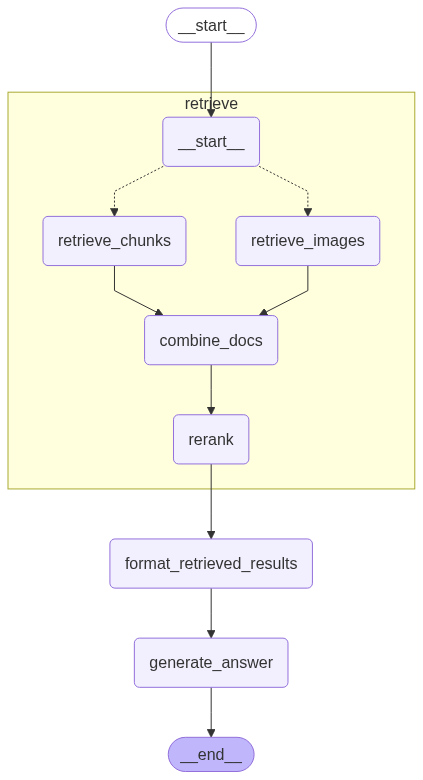

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain_openai import ChatOpenAI
from IPython.display import Image

# LLM 초기화
llm = ChatOpenAI(model="gpt-4.1", temperature=0)

# 시스템 메시지 정의
system_message = """당신은 인구 분석 전문가입니다. 사용자의 질의에 대해 제공된 참고 문서를 기반으로 정확하고 상세한 답변을 생성해주세요.

다음 지침을 따라주세요:
1. 제공된 참고 문서의 내용을 정확히 분석하고 인용하여 답변하세요.
2. 통계 수치나 데이터가 포함된 경우 정확한 수치를 명시하세요.
3. 논리적이고 체계적으로 답변을 구성하세요.
4. 참고 문서에 없는 내용은 추측하지 말고, 문서 범위 내에서만 답변하세요.
5. 필요시 표의 내용을 텍스트로 설명하여 이해를 돕도록 하세요."""

user_message = "출처\n---\n{context}\n---\n\n질의: {query}\n답변:"
prompt = ChatPromptTemplate.from_messages([
    ("system", system_message),
    ("user", user_message)
])

rag_chain = prompt | llm | StrOutputParser()

class RAGState(TypedDict):
    query: str
    context: str
    answer: str
    final_docs: List[Document]

def format_retrieved_results(state: RAGState) -> RAGState:
    """문서 포매팅"""
    return {"context": "\n\n".join([doc.page_content for doc in state["final_docs"]])}

def generate_answer(state: RAGState) -> RAGState:
    """멀티모달 프롬프트 생성"""
    content = state["context"]
    query = state["query"]
    return {"answer": rag_chain.invoke({"context": content, "query": query})}

# 워크플로우 생성
builder = StateGraph(RAGState)

# 노드 추가
builder.add_node("retrieve", retrieve_workflow)
builder.add_node("format_retrieved_results", format_retrieved_results)
builder.add_node("generate_answer", generate_answer)

# 엣지 추가
builder.add_edge(START, "retrieve")
builder.add_edge("retrieve", "format_retrieved_results")
builder.add_edge("format_retrieved_results", "generate_answer")
builder.add_edge("generate_answer", END)

# 워크플로우 정의
final_workflow = builder.compile()
display(Image(final_workflow.get_graph(xray=True).draw_mermaid_png()))

In [20]:
testset = [
    "2024년 인구주택총조사에서 미거주 주택(빈집) 현황은 어떻게 나타났나요?",
    "건축연도가 1989년 이전인 빈집의 비율과 특징을 설명해주세요.",
    "2025년 5월 경제활동인구조사에서 청년층의 취업률은 어떻게 나타났나요?",
    "청년층의 고용 현황과 주택 문제 사이의 관련성을 분석해주세요.",
    "인구주택총조사와 경제활동인구조사 결과를 종합하여 청년층의 주거 안정성에 대해 설명해주세요."
]

> 답변 생성 오래 걸림
> - 검색 : 1분 내외
> - 답변 생성 : 5분 내외

In [ ]:
response = final_workflow.invoke({"query": testset[0]})
response["answer"]

'2024년 인구주택총조사 기준 미거주 주택(빈집) 현황은 다음과 같이 나타났습니다.\n\n---\n\n### 1. 전국 미거주 주택(빈집) 규모 및 비율\n\n- **총 미거주 주택(빈집) 수**: 1,599천 호\n- **전체 주택 대비 미거주 주택 비율**: 8.0%\n  - 전년(2023년) 대비 미거주 주택 수는 64천 호(4.2%) 증가\n  - 미거주 주택 비율은 0.2%p 증가(2023년 7.9% → 2024년 8.0%)\n- **5년 전(2019년)과 비교**:\n  - 미거주 주택 수는 81천 호(5.4%) 증가\n  - 미거주 주택 비율은 0.3%p 감소(2019년 8.4% → 2024년 8.0%)\n- **총 주택 수**: 19,873천 호(전년 대비 326천 호, 1.7% 증가)\n\n---\n\n### 2. 시도별 미거주 주택(빈집) 비율\n\n- **빈집 비율이 가장 높은 지역**:\n  - 전남: 15.0%\n  - 제주: 14.2%\n  - 강원, 경북: 각각 12.5%\n- **빈집 비율이 가장 낮은 지역**:\n  - 서울: 3.2%\n  - 대전: 5.6%\n  - 경기: 5.8%\n- **특징**: 지방(특히 전남, 제주, 강원, 경북 등)에서 빈집 비율이 높고, 수도권 및 대도시(서울, 경기, 대전 등)에서는 낮은 경향\n\n---\n\n### 3. 노후기간 30년 이상 된 미거주 주택(빈집) 비율\n\n- **전국 평균**: 3.4%\n- **비율이 가장 높은 지역**:\n  - 전남: 8.8%\n  - 경북: 7.1%\n  - 전북: 6.6%\n- **비율이 가장 낮은 지역**:\n  - 세종: 1.0%\n  - 서울: 1.3%\n  - 대구: 1.4%\n- **분포 특징**: 남부 및 동부 지역(전남, 경북, 전북, 경남 등)에 노후 빈집이 집중되어 있음\n\n---\n\n### 4. 건축연도 및 주택 유형별 미거주 주택 현황\n\n- **1989년 이전 건축 주택**: 전체의 15.3%가 미거주(빈집) 상태\n  

In [24]:
response = final_workflow.invoke({"query": testset[1]})
response["answer"]

🔍 Reranking


'건축연도가 1989년 이전인 빈집(미거주 주택)의 비율과 특징은 다음과 같습니다.\n\n### 1. 빈집 비율 및 수치\n\n- **총주택 수**: 1989년 이전에 건축된 주택은 총 3,067천 호입니다.\n- **빈집 수**: 이 중 미거주 주택(빈집)은 468천 호입니다.\n- **빈집 비율**: 1989년 이전 건축 주택의 빈집 비율은 **15.3%**로, 전체 건축연도 구간 중 가장 높습니다.\n\n### 2. 주택 유형별 빈집 비율(1989년 이전)\n\n- **단독주택**: 1,786천 호 중 301천 호가 빈집으로, 빈집 비율은 **16.8%**입니다.\n- **아파트**: 899천 호 중 104천 호가 빈집으로, 빈집 비율은 **11.6%**입니다.\n- **연립주택**: 166천 호 중 26천 호가 빈집으로, 빈집 비율은 **15.6%**입니다.\n- **다세대주택**: 151천 호 중 25천 호가 빈집으로, 빈집 비율은 **16.6%**입니다.\n- **비주거용 건물 내 주택**: 64천 호 중 12천 호가 빈집으로, 빈집 비율은 **18.6%**입니다.\n\n### 3. 특징 및 시사점\n\n- **노후주택의 빈집 집중**: 1989년 이전에 건축된 주택은 전체 주택 중 빈집 비율이 가장 높아, 노후주택의 미거주 문제가 심각함을 보여줍니다.\n- **주택 유형별로도 높은 빈집 비율**: 특히 단독주택(16.8%), 다세대주택(16.6%), 비주거용 건물 내 주택(18.6%) 등에서 빈집 비율이 15%를 상회합니다. 이는 해당 유형의 노후주택이 상대적으로 더 많이 방치되고 있음을 시사합니다.\n- **아파트도 예외 아님**: 아파트 역시 11.6%의 빈집 비율을 보여, 노후 아파트의 미거주 현상도 무시할 수 없는 수준입니다.\n- **정책적 시사점**: 1989년 이전 건축 주택의 높은 빈집 비율은 주택 관리, 도시재생, 빈집 활용 정책 수립에 있어 우선적으로 고려해야 할 대상임을 의미합니다.\n\n### 4. 요약\n\n- 1989년 이

In [25]:
response = final_workflow.invoke({"query": testset[2]})
response["answer"]

🔍 Reranking


'2025년 5월 경제활동인구조사에 따르면, 청년층(15~29세)의 취업률(고용률)은 **46.2%**로 나타났습니다. 이는 전체 인구(15세 이상) 고용률 63.8%에 비해 17.6%p 낮은 수치입니다.\n\n세부적으로 살펴보면, 청년층 총인구는 7,974천명(797만 4천명)이며, 이 중 취업자는 3,682천명(368만 2천명)입니다. 청년층의 고용률 46.2%는 전년 동월 대비 0.7%p 하락한 수치로, 청년층의 경제활동참가율(49.5%) 역시 0.8%p 감소하였습니다.\n\n수학상태별로 보면,\n- **졸업자**(졸업, 중퇴, 수료 포함)는 4,175천명(417만 5천명)으로, 이 중 취업자는 2,962천명(296만 2천명)으로 **취업률 약 71%**를 기록하였습니다.\n- **재(휴)학자**는 3,797천명(379만 7천명)이며, 이 중 취업자는 717천명(71만 7천명)으로 **취업률 약 18.9%**에 그쳤습니다.\n\n이처럼 청년층의 전체 고용률은 낮은 수준이며, 특히 재(휴)학자의 취업률이 매우 낮아 학업과 병행한 취업이 제한적임을 알 수 있습니다. 또한, 청년층 실업률은 6.6%로 전체 실업률(2.8%)보다 높아, 청년 고용시장의 어려움이 지속되고 있음을 시사합니다.\n\n**요약**\n- 2025년 5월 청년층(15~29세) 고용률: **46.2%**\n- 졸업자 취업률: **약 71%**\n- 재(휴)학자 취업률: **약 18.9%**\n- 전년 동월 대비 청년층 고용률: **0.7%p 하락**\n\n(출처: 2025년 5월 기준 수학상태별 경제활동인구 구성 및 고용통계, 경제활동인구조사 부가조사 결과)'

In [26]:
response = final_workflow.invoke({"query": testset[3]})
response["answer"]

🔍 Reranking


'청년층의 고용 현황과 주택 문제 사이의 관련성 분석\n\n1. **청년층 고용 현황 요약**\n\n- 2025년 5월 기준 청년층(15~29세) 인구는 797만 4천명으로, 15세 이상 인구의 17.4%를 차지하며 전년 동월 대비 20만명 감소하였습니다.\n- 청년층 경제활동인구는 394만 3천명(전년 대비 16만 4천명 감소), 취업자는 368만 2천명(15만명 감소), 실업자는 26만 2천명(1만 4천명 감소)입니다.\n- 경제활동참가율은 49.5%(0.8%p 하락), 고용률은 46.2%(0.7%p 하락)로 모두 감소 추세입니다.\n- 연령별 고용률은 15~19세 6.3%(1.1%p 하락), 20~24세 45.8%(0.7%p 하락), 25~29세 72.7%(변화 없음)입니다.\n- 청년층 비경제활동인구는 403만명으로, 이 중 14.5%가 취업시험을 준비하고 있습니다(0.6%p 증가).\n\n2. **주택 현황 요약**\n\n- 2024년 주택당 평균 거주인수는 2.6명으로, 5년 전(2019년) 대비 0.3명 감소하였습니다.\n- 주택 유형별 평균 거주인수는 단독주택 3.4명, 아파트 2.5명, 연립주택 2.2명, 다세대주택 2.1명으로 모두 감소 추세입니다.\n- 단독주택 내 평균 거주가구수는 1.9가구로 5년간 변화가 없으나, 다가구단독(3.9가구)과 영업겸용단독(2.9가구)은 소폭 증가하였습니다.\n- 주택 연면적별로는 60~100㎡ 이하 주택이 42.8%로 가장 많으며, 40~60㎡ 이하(28.3%), 40㎡ 이하(13.0%) 순입니다.\n\n3. **고용과 주택 문제의 관련성 분석**\n\n**(1) 청년층 고용 불안정과 주거 소형화**\n- 청년층의 고용률과 경제활동참가율이 모두 하락하고 있으며, 취업자 수 역시 감소하고 있습니다. 이는 청년층의 소득 불안정과 직결됩니다.\n- 주택당 평균 거주인수의 지속적 감소(2.9명→2.6명)와 소형 주택(60㎡ 이하) 비중의 증가(40㎡ 이하 13.0%, 40~60㎡ 이하 28.3%)는 청년층을 포함한

In [27]:
response = final_workflow.invoke({"query": testset[4]})
response["answer"]

🔍 Reranking


'청년층의 주거 안정성에 대해 설명하기 위해서는 인구주택총조사와 경제활동인구조사(특히 2025년 5월 청년층 부가조사) 결과를 종합적으로 살펴볼 필요가 있습니다. 아래에서는 경제활동 현황과 인구 구조를 바탕으로 청년층의 주거 안정성에 영향을 미치는 주요 요인을 분석합니다.\n\n---\n\n## 1. 청년층 인구 및 경제활동 현황\n\n- **청년층(15~29세) 인구**: 7,974천 명으로 전체 15세 이상 인구(45,734천 명)의 17.4%를 차지합니다.\n- **경제활동참가율**: 49.5%로 전년 동월 대비 0.8%p 감소하였으며, 고용률은 46.2%로 0.7%p 감소하였습니다.\n- **비경제활동인구**: 4,030천 명(청년층 기준)으로, 이 중 14.5%가 취업시험을 준비하고 있습니다.\n\n이러한 수치는 청년층의 절반 이상이 경제활동에 참여하지 않거나, 취업 준비 등으로 경제적 자립이 미흡한 상태임을 시사합니다. 이는 주거 안정성에 직접적인 영향을 미치는 요인입니다.\n\n---\n\n## 2. 청년층의 취업 및 소득 안정성\n\n- **졸업 후 첫 일자리 취업 소요기간**: 평균 11.3개월로, 졸업 후 1년 가까이 소득이 불안정한 상태가 지속됩니다.\n- **첫 일자리 근속기간**: 평균 1년 6.4개월로, 전년 대비 0.8개월 감소하여 일자리의 안정성이 약화되고 있습니다.\n- **첫 일자리 산업 분포**: 숙박음식업(16.3%), 광제조업(13.1%), 도소매(11.4%), 보건복지(11.3%), 교육서비스(8.0%) 순으로, 상대적으로 임금과 고용 안정성이 낮은 산업 비중이 높습니다.\n- **첫 일자리 이직률**: 첫 일자리를 그만둔 비율이 35.9%로, 전년 대비 1.6%p 증가하였고, 그만둔 주요 사유는 근로여건 불만족(46.4%)입니다.\n\n이처럼 청년층은 졸업 후 취업까지 시간이 오래 걸리고, 취업 후에도 근속기간이 짧으며, 이직률이 높아 소득의 지속성과 예측 가능성이 낮습니다. 이는 주거 마련 및 유지에 불리하게 작용합니